In [1]:
###############################################   LAB 5   ##############################################
################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2021 ############
##################### DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE #################
########################################################################################################
import numpy as np
import os,sys,re
import cv2
from PIL import Image as PILImage
import torch
import torchvision
from torchvision import transforms as transforms
import dataset_pascal as dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils import data
import matplotlib.pyplot as plt
import util
import torch.utils as utils
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from torchvision.models.segmentation import *

device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')
print(device)

cuda


In [3]:
pascal_object_categories = ['__bgr__', 'aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']


# convert list to dict
pascal_voc_classes = {}
for id, name in enumerate(pascal_object_categories):
    pascal_voc_classes[name] = id

# also names from ids
pascal_voc_classes_name = {}
for id, name in enumerate(pascal_object_categories):
    pascal_voc_classes_name[id] = name

print(pascal_voc_classes, len(pascal_voc_classes))



{'car': 7, 'cat': 8, 'boat': 4, 'motorbike': 14, 'train': 19, 'person': 15, 'bus': 6, 'horse': 13, 'cow': 10, 'bird': 3, 'sofa': 18, 'diningtable': 11, 'bottle': 5, 'chair': 9, 'tvmonitor': 20, 'sheep': 17, 'dog': 12, 'bicycle': 2, '__bgr__': 0, 'aeroplane': 1, 'pottedplant': 16} 21


In [3]:
# get MS COCO classes
coco_object_categories=[]
coco_classes={}
with open("coco_labels.txt","r") as f:
     for id, l in enumerate(f.readlines()):
         # get the class label
         l = re.sub('[\d]+\W+','', l.rstrip())
         # remove the old stuff
         if l == 'banner':
            break
         else:    
            coco_object_categories.append(l)
            coco_classes[l] = id

print(coco_object_categories, coco_classes)
img_max_size = [800,800]


['unlabeled', 'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'pottedplant', 'sofa', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush'] {'e

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Detected  __bgr__
Detected  cat
Detected  dog
Detected  sofa


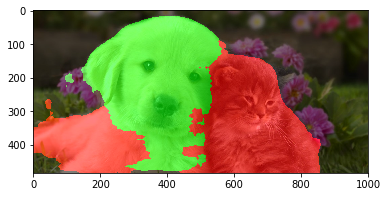

In [8]:
################### SEMANTIC SEGMENTATION ####################################
##
##
##
# This loads FCN model with ResNet101 backbone
fcn = segmentation.fcn_resnet101(pretrained=True, num_classes=21)
print(fcn)
fcn.eval()
# Evaluate the pretrained FCN model on one image
# Hacking exercise : make the output prettier, adding an arbitrary number 
# of objects-colors, matching the color gamma of Pascal VOC
# weghts were trained in a different framework, so need to multiply by 255
def deploy_fcn_model(im):
    im = PILImage.open(im)
    img = np.array(im, dtype=np.uint8)
    t_ = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.457, 0.407],
                    std=[1,1,1])])                    
    #multiply by 255 for the network input
    img = t_(img)    
    img.unsqueeze_(0)
    if device == torch.device("cuda"):
        img = img.to(device)
    # get the output from the model
    output = fcn(img)['out']    
    #remove from cuda, convert to numpy, squeeze
    out = output.argmax(1).squeeze_(0).detach().clone().cpu().numpy()    
        #load the image
    bgr_img = np.array(PILImage.open("dogcat1.jpg"))
    # convert FCN8s pixelwise predictions to color array
    color_array = np.zeros([out.shape[0], out.shape[1],3], dtype=np.uint8)
    for id in np.unique(out):
        print("Detected ", pascal_voc_classes_name[id])
        if id == 8:
            color_array[out==id] = [255,0,0]
        elif id == 12:
            color_array[out==id] = [0,255,0]            

    #overlay images
    added_image = cv2.addWeighted(bgr_img, 0.5, color_array,0.6, 0)
    #plot
    plt.imshow(added_image)
    plt.show()
    
deploy_fcn_model("dogcat1.jpg")   

# Modeling exercise: train fcn on Pascal VOC  
semantic_data_args= {'classes':pascal_voc_classes, 'img_max_size':(800,800), 'dir':'pascal/Images','dir_label_mask':'pascal/GT', 'problem':'semantic'}
semantic_data_point = dataset.PascalVOC2012DatasetSegmentation(**semantic_data_args)

semantic_dataloader_args = {'batch_size':1, 'shuffle':True}
semantic_dataloader = data.DataLoader(semantic_data_point, **semantic_dataloader_args)
# In the dataset class, use the method extract_segmentation_mask_pascal to get pixelwise labels 

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

tensor([[  9.9251,   8.8806, 677.0821, 485.0000],
        [492.6631, 123.1887, 868.1113, 482.4891]], grad_fn=<StackBackward>)


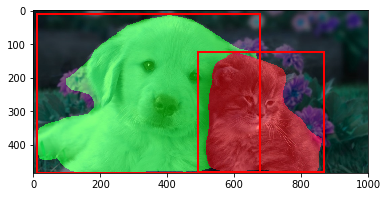

In [15]:
############################# INSTANCE SEGMENTATION #############################                                                                              
########      This loads Mask R-CNN model from torchvision repository         ###
#################################################################################

maskrcnn_args = {'num_classes':91, 'box_score_thresh':0.75}

####################### EVAL OF THE PRETRAINED MODEL #############################
maskrcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, **maskrcnn_args)
print(maskrcnn_model)
maskrcnn_model.eval()
# deploy the pretrained Mask R-CNN model on an image
# hacking exercise: make the output prettier,
# add predicted class, make the boundary thicker 
# depending on the confidence, add mask contours, etc
def deploy_mask_rcnn(im):
    im = PILImage.open(im)
    img = np.array(im)
    img = transforms.ToTensor()(img)
    print(img.size())
    out = maskrcnn_model([img])
    # scores + bounding boxes + labels + masks
    scores = out[0]['scores']
    bboxes = out[0]['boxes']
    classes = out[0]['labels']
    # masks: unmolded, size of the whole image
    print(bboxes)
    mask = out[0]['masks']
    color_array = np.zeros([mask[0].shape[1], mask[0].shape[2],3], dtype=np.uint8)
    # for the objects with scores>threshold: 
    # add bbox and mask 
    if len(scores):
       bgr_img = cv2.imread("dogcat1.jpg")
       #plt.imshow(im)
       ax = plt.gca()
       # plot masks
       # Do not use pytorch tensors 
       # before plotting, convert to numpy
       for id, b in enumerate(bboxes):
           if classes[id] == 17:
              found = mask[id][0].detach().clone().cpu().numpy()
              color_array[found>0.5] = [255,0,0]
           elif classes[id] ==18:
              found = mask[id][0].detach().clone().cpu().numpy()
              color_array[found>0.5] = [0,255,0]
           rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
           ax.add_patch(rect)

       added_image = cv2.addWeighted(bgr_img, 0.5, color_array, 0.5, 0)       
       plt.imshow(added_image)
       plt.show()

deploy_mask_rcnn("dogcat1.jpg")

In [6]:
# Modeling exercise: finetune the data to Pascal VOC 2012 dataset
# If you use a different number of classes, you need to change the output of the class prediction layer
instance_data_args= {'classes':pascal_voc_classes, 'img_max_size':(512,512), 'dir':'pascal/Images','dir_label_bbox':'pascal/annotations', 'dir_label_mask':'pascal/GT', 'problem':'instance'}
instance_data_point = dataset.PascalVOC2012DatasetSegmentation(**instance_data_args)

instance_dataloader_args = {'batch_size':1, 'shuffle':True}
instance_dataloader = data.DataLoader(instance_data_point, **instance_dataloader_args)
total_epochs = 20

# create another model
maskrcnn_train_args = {'pretrained':False, 'num_classes':21, 'rpn_batch_size_per_image':256, 'box_batch_size_per_image':256, 'min_size':512, 'max_size':1024}
maskrcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(**maskrcnn_train_args)
print(maskrcnn_model)
maskrcnn_model.train()

if device == torch.device('cuda'):
   maskrcnn_model = maskrcnn_model.to(device)

instance_optimizer_pars = {'lr':1e-5, 'weight_decay':1e-3}
instance_optimizer = torch.optim.SGD(list(maskrcnn_model.parameters()),**instance_optimizer_pars)

for e in range(total_epochs):
    epoch_loss = 0
    for id, batch in enumerate(instance_dataloader):
        instance_optimizer.zero_grad()
        idx,X,y = batch
        #print(idx, y)
        if device == torch.device('cuda'):
           X,y['labels'],y['boxes'], y['masks'] = X.to(device), y['labels'].to(device), y['boxes'].to(device), y['masks'].to(device)
        # list of images
        images = [im for im in X]
        targets = []
        lab={}
        # THIS IS IMPORTANT!!!!!
        # get rid of the first dimension (batch)
        # IF you have >1 images, make another loop
        # REPEAT: DO NOT USE BATCH DIMENSION 
        lab['boxes'] = y['boxes'].squeeze_(0)
        lab['labels'] = y['labels'].squeeze_(0)
        lab['masks'] = y['masks'].squeeze_(0)        
        targets.append(lab)
        # avoid empty objects
        if len(targets)>0:
           loss = maskrcnn_model(images, targets)
           total_loss = 0           
           for k in loss.keys():
               total_loss += loss[k]
           epoch_loss += total_loss.item()
           total_loss.backward()
           instance_optimizer.step()
    epoch_loss = epoch_loss/len(instance_dataloader)    
    print("Loss = {0:.4f} in epoch {1:d}.".format(epoch_loss, e))
        

# Modeling exercise: save the trained model and evaluate on Pascal VOC validation set using ground truth 
# and predicted masks,compare it to the detection loss from the previous lab

# Modeling exercise + hacking exercise: use a differnt feature extractor, e.g. ResNet101, pretrained weights:
# https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
# ResNeXt50, 32x8d:
# https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

Loss = 4.4402 in epoch 0.
Loss = 3.9534 in epoch 1.
Loss = 2.3243 in epoch 2.
Loss = 2.0000 in epoch 3.
Loss = 1.7500 in epoch 4.
Loss = 1.6352 in epoch 5.
Loss = 1.5802 in epoch 6.
Loss = 1.5496 in epoch 7.
Loss = 1.5270 in epoch 8.
Loss = 1.5103 in epoch 9.
Loss = 1.4992 in epoch 10.
Loss = 1.4904 in epoch 11.
Loss = 1.4827 in epoch 12.
Loss = 1.4766 in epoch 13.
Loss = 1.4709 in epoch 14.
Loss = 1.4662 in epoch 15.
Loss = 1.4619 in epoch 16.
Loss = 1.4584 in epoch 17.
Loss = 1.4542 in epoch 18.
Loss = 1.4508 in epoch 19.


In [7]:
maskrcnn_model.eval()
torch.save(maskrcnn_model, "maskrcnn_pascal_voc.pth")